In [15]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import random as RD
from matplotlib import colors
from tqdm import tqdm
import pickle
import pathlib

In [38]:
class parameters:
    
    def __init__(self):
        self.numEquations = 4
        self.stepSize = 0.1
        self.simLength = 400 #42000
        self.tarray = np.arange(0,self.simLength,self.stepSize)
        self.Ntimes = len(self.tarray)
        self.spikeThreshold = 5 # Sets the voltage(mV) at which a spike is recorded. 
        self.numnrn = 1 #180 # Number of neurons in the model.
        self.numSST = 0 #int((1/9)*self.numnrn) #20 # Number of SST neurons to be forced into the model.
        self.numBB =  0# Number of backbones to be created.
        self.numnrn_BB = int((self.numBB*2/9)*self.numnrn) # Number of neurons in all backbones combined.
        self.c_e = 0 #0.1 # Percent connectivity for excitatory neurons.
        self.c_i = 0 #0.5 # Percent connectivity for inhibitory neurons.
        self.p_e = 0 # Probabilty of an existing connection shuffling during network creation, excitatory.
        self.p_i = 0 # Probabilty of an existing connection shuffling during network creation, inhibitory.
        self.local_conn = True # When true, new connections can be formed with local connections. When false, only non-local new
                        # connections are formed.
            
        self.gks_NREM = 1.5 # ACh level of neurons during NREM phase. Type I is gks=0, Type II gks=1.5.
        self.gks_REM = 0 # ACh level for neurons during REM phase.
        self.gks_test = 0.1 # ACh level for neurons during testing phases.
        # self.Idrive_min = 0.5 # Lower range for possible random Idrives. For excitory neurons.
        # self.Idrive_max = 0.5 # Upper range for possible random Idrives. For excitory neurons.
        self.Idrive_BB = 0.5 # The Idrive for BB neurons. Should be high enough to induce firing.
        self.Idrive_NABB = -6 # Idrive for the non-active backbone, should be low enough to prevent any firing outside of noise.
        self.Idrive_SST = -0.1 #The Idrive for inhibitory SST neurons. Should be low enough so that they do not fire without synaptic input. 
        self.quad_colors = ['blue', 'green', 'purple', 'pink'] # Colors for the groups of less excitable (LE) neurons. 
        # Blue: higher connectivity to BB1, Green: higher connectivity to BB2, Purple: higher connectivity to both BBs, Pink: lower connectivity to both BBs.
        self.Idrive_quad = [0.5, 0.5, -6, -6] # Idrive to be assigned to LE neurons.
        

        self.w_max = 5 #Maximum positive synaptic plasticity multiplier allowed in network.
        
        self.NABP_boo = True #True # When true, non-active backbone has plasticity. When False, it does not. 
        self.makeSound = True # Determines whether to play the three tones after simulation is finished.
        self.plas_skip_time = 200 #200 # Time before spikes start being recorded (in ms) and plasticity begins.
        self.NREMtest_boo = False # Currently not used anywhere. Needs code needs to be added to make the NREM testing phase optional.
        self.RD_seed = True # When true, a seed is used to generate connections
        self.sim_seed = 4 # The seed for generating all random elements of the simulation. Defining a seed before a
                        # sequence of random events will not only define the outcome of the first random choice/event, but
                        # also the following ones. So we only need one seed.
        self.bbs_toplot = [1,2] # list of backbones to plot by ID.
        self.sim_dir = r'/home/msatchell/Documents/Zochowski Lab/Simulations/Single Neuron/gks=0/defaults/' # The simulation parent directory for all files.
        self.data_dir = self.sim_dir + '/Data' # The data directory for all files to be saved to. Must be created before the simulation is run.
        
        self.osc_period = 500 # The amount of time each BB is active in the oscillations. Note that param.osc_period under 1000*param.plas_thr will
                        # likely cause large depotentiation problems. Also, we need param.osc_period < 1000/param.dep_thr to 
                        # prevent large depotentiation.
                        
        self.lessen_BB_act = False # When true, one BB is active for less time than the other BB.
        self.BB_act_scale = 0.5 # The scale factor for the active BB. The less active BB will have a scale factor of 1 - param.BB_act_scale.
        self.lessen_BB_Idrive = False # When true, one BB has a lower Idrive than the other during NREM and REM.
        self.BB_Idrive_factor = 0.5 # The factor by which to decrease the Idrive of the less active BB.
        self.BB_todecrease = 1 # The BB ID to decrease Idrive of. 1 is blue, 2 is green.
        self.equal_BB_LE_inh = False # When true, BBs and LE neurons receive the same strength of inhibitory connections, and 
        # the Idrive for BBs is raised and for LE neurons lowered to account for this.
        self.SSTtoLEBB_mult = 3.5 # Multiplier for connections from SST to LE and BB neurons.
        self.change_Idrive_BB = 14.5 # Amount to change Idrive of BB neurons by.
        self.change_Idrive_LE = 0 # Amount to change Idrive of LE neurons by.
        
        self.num_test_phases = 3 # Number of test phases in simulation. Right now we have 3: pre-learning test, 
                        # post-NREM test, and post-learning test.
        self.BB_len_test = 3000 #3000 when simLength=42000 # Length of test phase for each BB (in ms). Total pre- and post- test phase length is then 2*param.BB_len_test.
        self.BB_len_NREM = 6000 #6000 when simLength=42000 #int((self.simLength - 2*self.num_test_phases*self.BB_len_test)/4) # The length of NREM for each BB (in ms).
        self.BB_len_REM = 6000 #6000 when simLength=42000 #int((self.simLength - 2*self.num_test_phases*self.BB_len_test)/4) # The length of REM for each BB (in ms).
        self.t_start_NREM = 2*self.BB_len_test # Time at which NREM begins.
        self.t_start_NREMtest = self.t_start_NREM + 2*self.BB_len_NREM # Time at which the test phase after NREM begins.
        self.t_start_REM = self.t_start_NREMtest + 2*self.BB_len_test # Time at which REM begins.
        self.t_start_posttest = self.t_start_REM + 2*self.BB_len_REM # Time at which the post-learning test phase begins.
        self.storage_freq = 50 # How often (in ms) to store connection weight data for each neuron. A value of 10 collects data every 
                        # 10 ms. At 1 ms, I was having memory issues on Michal's PC because the arrays were getting too large.
        
        self.w_EE = 0.15 # AMPA connection strength excitatory to excitatory.
        self.w_EI = 0.08 # AMPA connection strength excitatory to inhibitory.
        self.w_II = 0.15 # GABA A connection strength inhibitory to inhibitory.
        self.w_IE = 0 # GABA A connection strength inhibitory to excitatory.
        self.w_II_B = 0 # GABA B connection strength inhibitory to inhibitory.
        self.w_IE_B = 0.05 # GABA B connection strength inhibitory to excitatory.
        
        self.LEtoBB_mult = 1 # Multiplier for connections from LE to BB neurons.
        self.LEtoLE_mult = 1 # Multiplier for connections from LE to LE neurons.
        self.LEtoSST_mult = 1 # Multiplier for connections from LE to SST neurons.
        self.BBtoLE_mult = 1 # Multiplier for connections from BB to LE neurons.
        self.BBtoBB_mult = 2.5 # Multiplier for connections from BB to BB neurons.
        self.SSTtoLE_mult = 3.5 # Multiplier for connections from SST to LE neurons.
        self.SSTtoBB_mult = 0.5 # Multiplier for connections from SST to BB neurons.
        
        self.A_dep = 0.025 # The maximum amount a synapse can depotentiate per spike.
        self.A_pot = 0.07 # The maximum amount a synapse can potentiate per spike.
        self.tau_dep = 34 # Time constant for depotentiation side of STDP rule.
        self.tau_pot = 14 # Time constant for potentiation side of STDP rule.
        self.const_ISI = 30 # The inter-spike interval (in ms) at which to freeze the magnitude of the depotentiation portion
        # of the STDP rule so that it stays constant for larger ISIs.
        
        self.LEtoLE_plas_mult = 0.3 # Multiplier to modify the plasticity rate of LE to LE connections.
        self.LEtoBB_plas_mult = 0.3 # Multiplier to modify the plasticity rate of LE to BB connections.

        self.bg_str = 0.5 # The amount to strengthen connections from BB to blue and green LE neurons.
        self.pu_weak = 0 # The amount to weaken connections from both BBs to purple LE neurons.
        self.pi_weak = 0 # The amount to weaken connections from both BBs to pink LE neurons.
        

        
            

def init_param(): # Function to simply initialize a parameter object. Desired changes to parameters should be made here,
    # as opposed to being made in the parameter class function (except changes that affect definitions within the parameter
    # class definition). ACh (gks) level, BB activity, and plasticity lists are added to the parameter object here.

    param = parameters()
    
    # The directory must be updated to have forward slashes, including a forward slash on the end.
    param.data_dir = param.data_dir.replace('\\','/') # Replaces backslash "\" with forward slash "/".
    param.data_dir = param.data_dir + '/' # Adds forward slash to end of string.
    
    # Add attributes to param pertaining to times when gks values change:
    
    #List containing gks values and the time to impliment them. [[gks val,time(ms)],[...]].
    # Simulation with initial test, NREM, post-NREM test, REM, and final test phases.
    gkst_list = [[param.gks_test, 0], [param.gks_NREM, param.t_start_NREM], \
               [param.gks_test, param.t_start_NREMtest], [param.gks_REM, param.t_start_REM],\
               [param.gks_test, param.t_start_posttest]] 
    # # For a simulation without test phases and only NREM followed by REM.
    # gkst_list = [ [param.gks_NREM, param.t_start_NREM], \
    #             [param.gks_REM, param.t_start_REM]] 
    gks_times = [i[1] for i in gkst_list]
    # create new attributes for these lists.
    param.gkst_list = gkst_list
    param.gks_times = gks_times
    
    # For varying backbone activity:
    bbt_list = [] # Will hold BB activity for learning times.
    
    if param.lessen_BB_act == True: # If one BB is active for less time than the other.
        # I shouldn't change BB_len_NREM/REM because this time is still used for one of the BBs.
        param.simLength = round(param.simLength - (param.BB_len_NREM + param.BB_len_REM)*(1-param.BB_act_scale)) # Updates simLength.
        param.tarray = np.arange(0,param.simLength,param.stepSize) # Updates tarray.
        param.Ntimes = len(param.tarray) # Updates Ntimes.
        param.t_start_NREM = 2*param.BB_len_test # Time at which NREM begins.
        param.t_start_NREMtest = param.t_start_NREM + param.BB_len_NREM + round(param.BB_len_NREM*(1-param.BB_act_scale)) # Time at which the test phase after NREM begins.
        param.t_start_REM = param.t_start_NREMtest + 2*param.BB_len_test # Time at which REM begins.
        param.t_start_posttest = param.t_start_REM + param.BB_len_REM + round(param.BB_len_REM*(1-param.BB_act_scale)) # Time at which the post-learning test phase begins.

        NREM_osc_times_short_BB = list(range(param.t_start_NREM, param.t_start_NREMtest, round(param.osc_period+param.osc_period*(1-param.BB_act_scale)))) #List of times for switching BBs in NREM.
        NREM_oc_times_reg_BB = list(range(param.t_start_NREM + round(param.osc_period*(1-param.BB_act_scale)), param.t_start_NREMtest, round(param.osc_period+param.osc_period*(1-param.BB_act_scale)))) #List of times for switching BBs in NREM.
        NREM_osc_times = NREM_osc_times_short_BB + NREM_oc_times_reg_BB # Concatenates lists to create one list with all oscillation switch times.
        NREM_osc_times.sort() # Sorts the list of times for switching BBs in NREM.
        REM_osc_times_short_BB = list(range(param.t_start_REM, param.t_start_posttest, round(param.osc_period+param.osc_period*(1-param.BB_act_scale)))) #List of times for switching BBs in REM.
        REM_osc_times_reg_BB = list(range(round(param.t_start_REM + param.osc_period*(1-param.BB_act_scale)), param.t_start_posttest, round(param.osc_period+param.osc_period*(1-param.BB_act_scale)))) #List of times for switching BBs in REM.
        REM_osc_times = REM_osc_times_short_BB + REM_osc_times_reg_BB # Concatenates lists to create one list with all oscillation switch times.
        REM_osc_times.sort() # Sorts the list of times for switching BBs in REM.
    else:
        # List indicating times and implimentations. [ [ ['on',[bbs to turn on],'off',[bbs to turn off] ], time(ms)] , [...] ]
        tot_learning_time = param.simLength - 2*param.num_test_phases*param.BB_len_test #Total learning time, i.e. time not spent in either test phase.
        num_osc = np.floor(tot_learning_time/param.osc_period) # Number of oscillations between BBs during learning.
        NREM_osc_times = list(range(param.t_start_NREM,param.t_start_NREMtest,param.osc_period)) #List of times for switching BBs in NREM.
        REM_osc_times = list(range(param.t_start_REM,param.t_start_posttest,param.osc_period)) #List of times for switching BBs in REM.
    
    osc_times = NREM_osc_times + REM_osc_times # Concatenates lists to create one list with all oscillation switch times.
    # Now that I have the times to switch the oscillations at, I need to put them into the form of 
    # [ [ ['on',[bbs to turn on],'off',[bbs to turn off] ], time(ms)] , [...] ].
    BB_onoff = [ ['on',[1],'off',[2]] , ['on',[2],'off',[1]] ] # Holds the 2 options for turning BBs on and off. 
    onoff_index = 0 #Used to assign index from BB_onoff. If initialized at 0, starts with blue BB. If at 1, starts with green.
    for osc_t in osc_times: # Loops through times at which to switch BBs.
        bbt_list.append([BB_onoff[onoff_index], osc_t ])
        if onoff_index == 0: #This keeps switching between BB_onoff indices.
            onoff_index = 1
        else:
            onoff_index = 0 
    insert_values = [[['on',[1],'off',[2]],0], [['on',[2],'off',[1]],param.BB_len_test], [['on',[1],'off',[2]],param.t_start_NREMtest],
                     [['on',[2],'off',[1]],param.t_start_NREMtest+param.BB_len_test], [['on',[1],'off',[2]],param.t_start_posttest],
                     [['on',[2],'off',[1]],param.t_start_posttest+param.BB_len_test]] #Values (for test phases) to be inserted.
    # Adding the testing phases to the list.
    bbt_list.insert(0,insert_values[0]) # Inserting BB activity rules for pre-learning test.
    bbt_list.insert(1,insert_values[1])
    # It is more difficult to insert the post-NREM test phase because I have to know between exactly which oscillations
    # to place it. Previously, I had converted bbt_list to an array for using np.where() so I could correctly insert test phase bb activity rules. However,
    # numpy arrays don't like the ragged list that bbt_list is, so I will keep bbt_list as a list and extract the bb activity switch times, then 
    # find the indicies of the times I want to insert the test phase rules at.
    temp_bbt_times = [i[1] for i in bbt_list] # Extracts times from bbt_list.
    post_NREM_times = [i for i in temp_bbt_times if i > param.t_start_NREMtest] # Extracts times after NREM.
    min_idx = temp_bbt_times.index(min(post_NREM_times))
    bbt_list.insert(min_idx,insert_values[2]) # Inserts BB activity rules for post-NREM test.
    bbt_list.insert(min_idx+1,insert_values[3])
    bbt_list.append(insert_values[-2]) # BB activity rules for post-learning test.
    bbt_list.append(insert_values[-1])
    bb_times = [i[1] for i in bbt_list]
    param.bbt_list = bbt_list
    param.bb_times = bb_times
             
    #For varying plasticity activity:
    #List for turning off plasticity to and from specific bbs or LE neurons. [[LE,bb1,bb2],time] , ...
    plast_list = [[[False,False,False],0], [[False,False,False],param.t_start_NREMtest], [[False,False,False],param.t_start_posttest]]
    if param.NABP_boo == True: #For NABP on.
        # Turns plasticity on during NREM and REM phases, delayed by 2*osc_period.
        plast_list.insert(1,[[True,True,True],param.t_start_NREM + 2*param.osc_period])
        plast_list.insert(3,[[True,True,True],param.t_start_REM + 2*param.osc_period]) 
    # Loop through bbt_list used for BB activity and use it to create the plasticity activity list.
    if param.NABP_boo == False: #Only adds these elements if NABP is supposed to be off. 
        for item in bbt_list:
            if item[1] >= param.t_start_NREM and item[1] < param.t_start_NREMtest or item[1] >= param.t_start_REM and \
            item[1] < param.t_start_posttest: #If the time related to the command is in learning:
                if item[0][1] == [1] and item[0][3] == [2]:
                    plast_list.insert(-1, [[True,True,False],item[1]] ) # Adds element for turning on BB1.
                if item[0][1] == [2] and item[0][3] == [1]:
                    plast_list.insert(-1, [[True,False,True],item[1]] ) # Adds element for turning on BB2.     
    plas_times = [i[1] for i in plast_list]
    param.plast_list = plast_list
    param.plas_times = plas_times
    
    # Equal inhibition to BBs and LE neurons:
    if param.equal_BB_LE_inh == True:
        param.SSTtoLE_mult = param.SSTtoLEBB_mult
        param.SSTtoBB_mult = param.SSTtoLEBB_mult
        # Adjust Idrive for LE neurons to account for equal inhibition. Two lists cannot simply have their elements added using '+'.
        param.Idrive_quad = [sum(x) for x in zip(param.Idrive_quad,[param.change_Idrive_LE]*len(param.Idrive_quad))] 
        param.Idrive_BB = param.Idrive_BB + param.change_Idrive_BB
        
    return param


        

class neuron:
        
    def __init__(self):
        self.ID = 0
        self.position = []
        self.connections = [] #List of (1 or 0) connection strengths to other neurons. Is 2D list like [[postsyn,conn],[postsyn,conn]...].
        # DO NOT CHANGE self.connections from values of only 1 and 0 because many apects of the program rely on it.
        self.connectionWeights = [] #Holds changes made from plasticity. For self as presynaptic nrn. Values are strengths of
        # signal to other neurons from this neuron.
        self.Input_syn = 0
        self.Input_noise = 0
        self.Input_external = 0
        self.spikeTimes = [] # Set to record a spike when membrane voltage breaches variable param.spikeThreshold.
        self.prevActivity = 0
        self.neuronsInRange = [] #Tracks the # of neurons in range so as to minimize looping time during connection growth function
        self.solutions = np.zeros(param.numEquations) #Why does nrn.solutions still function as a comment?
        self.soln_history = np.zeros((param.numEquations,param.Ntimes)) #Holds the voltage of the neuron at each time step.
        
        #Things I have added in myself:
        self.gks = 0#param.gks_test # gks value for neuron, determines effective ACh concentration.
        self.spike = False #Determines whether the neuron has already spiked or not. 
        self.Idrive = 0
        self.color = '' #Color of neuron for graphing.
        self.conn_in = [] #Connections coming in from other neurons. Sum is the in-degree of the neuron. Note, not tuple like self.connections.
        # Format is 1D list of connection strengths, where list index is presynaptic neuron. 
        self.category = 'Excitatory' #Labels the neuron type. Default is excitatory, can be chanegd to inhibitory. 
        self.pair_spiketimes = np.zeros(param.numnrn) #Pair spike times for outgoing connections. Note that this only holds the most recent pair spiketime for each conn.
        self.start_noise = 0 #Starting step time for noise when it occurs (mV/param.stepSize). 
        self.backbone_ID = 0 # backbone_ID=0 will be used to designate lower E neurons and -1 for inhibitory neurons.
        self.spike_gaussian = [] #List of gaussian curves, each centered at the time a neuron spikes. Each index in list corresponds to a t_ind time.
        self.plas_on = True #Boolean determining whether or not to change plasticity of connections TO and FROM this nrn. 
        self.cw_in_history = [] #Connection weight history. Holds plasticity connection weights coming IN (this nrn as postsyn).
        # Set up as [[[weight from nrn 0, weight from nrn 1, ... ],time(ms)] ,...], one weight list for each milisecond.
        # List set up to skip first plas_skip_time ms because we don't want plasticity due to transient behaviors. Note the default
        # value for connections and non-existent connections is 1. 
        self.cw_out_history = [] # Same as cw_in_history, just with this nrn as the presynaptic neuron.
        self.scatter_color = 'grey'
        self.quad_color = 'grey' # Color assigned to LE neurons based on initial connectivity to BBs.

        
        
def equations(solns_, eqn, Isyn, Idrive,nrn):
    
    
    tempVal = 0
    
    category = nrn.category
    Inoise = nrn.Input_noise # Noise from neuron. Maybe I should put Idrive, solns, etc here as well?
    
    if category == 'Excitatory':
        gks = nrn.gks
        C = 1 
        gna = 24
        gkdr = 3
        gl = 0.02
        Vna = 55
        Vk = -90
        Vl = -60
        if(eqn == 0):
            hinf = 1/(1+np.exp((solns_[3]+53)/7))
            tauh = .37 + 2.78/(1+np.exp((solns_[3]+40.5)/6))
            tempVal = (hinf - solns_[0])/tauh 
        elif(eqn == 1):
            ninf = 1/(1+np.exp((-solns_[3]-30)/10))
            taun = .37 + 1.85/(1+np.exp((solns_[3]+27)/15))
            tempVal = (ninf - solns_[1])/taun
        elif(eqn == 2):
            zinf = 1/(1+np.exp((-solns_[3]-39)/5))
            tempVal = (zinf - solns_[2])/75
        elif(eqn == 3):
            m = 1/(1+np.exp((-solns_[3]-30)/9.5))
            tempVal = (-gna*(m**3)*solns_[0]*(solns_[3]-Vna) - gkdr*(solns_[1]**4)*(solns_[3]-Vk) 
                       - gks*solns_[2]*(solns_[3]-Vk) - gl*(solns_[3]-Vl) + Idrive - Isyn + Inoise)/C
            
    elif category == 'SST':
        gks = nrn.gks
        C = 1 
        gna = 24
        gkdr = 3
        gl = 0.02
        Vna = 55
        Vk = -90
        Vl = -60
        if(eqn == 0):
            hinf = 1/(1+np.exp((solns_[3]+53)/7))
            tauh = .37 + 2.78/(1+np.exp((solns_[3]+40.5)/6))
            tempVal = (hinf - solns_[0])/tauh 
        elif(eqn == 1):
            ninf = 1/(1+np.exp((-solns_[3]-30)/10))
            taun = .37 + 1.85/(1+np.exp((solns_[3]+27)/15))
            tempVal = (ninf - solns_[1])/taun
        elif(eqn == 2):
            zinf = 1/(1+np.exp((-solns_[3]-39)/5))
            tempVal = (zinf - solns_[2])/75
        elif(eqn == 3):
            m = 1/(1+np.exp((-solns_[3]-30)/9.5))
            tempVal = (-gna*(m**3)*solns_[0]*(solns_[3]-Vna) - gkdr*(solns_[1]**4)*(solns_[3]-Vk) 
                       - gks*solns_[2]*(solns_[3]-Vk) - gl*(solns_[3]-Vl) + Idrive - Isyn)/C
            
    elif category == 'PV+':
        gks = nrn.gks
        C = 1 
        gna = 35
        gkdr = 9
        gl = 0.1
        Vna = 55
        Vk = -90
        Vl = -65    
        if(eqn == 0):
            a_h = 0.07*np.exp(-(solns_[3]+58)/20)
            b_h = 1/(np.exp(-0.1*(solns_[3]+28))+1)
            phi = 5
            tempVal = phi*(a_h*(1-solns_[0]) - b_h*solns_[0])
        elif(eqn == 1):
            a_n = -0.01*(solns_[3]+34)/(np.exp(-0.1*(solns_[3]+34))-1)
            b_n = 0.125*np.exp(-(solns_[3]+44)/80)
            phi = 5
            tempVal = phi*(a_n*(1-solns_[1])-b_n*solns_[1])
        elif(eqn == 2):
            zinf = 1/(1+np.exp((-solns_[3]-39)/5))
            tempVal = (zinf - solns_[2])/75
        elif(eqn == 3):
            a_m = -0.1*(solns_[3]+35)/(np.exp(-0.1*(solns_[3]+35))-1)
            b_m = 4*np.exp(-(solns_[3]+60)/18)
            m = a_m/(a_m+b_m)
            tempVal = (-gna*(m**3)*solns_[0]*(solns_[3]-Vna) - gkdr*(solns_[1]**4)*(solns_[3]-Vk) 
                       - gks*solns_[2]*(solns_[3]-Vk) - gl*(solns_[3]-Vl) + Idrive - Isyn)/C
        
    return tempVal


def RK4(t_ind):
    
    global neuron
    
    for nrn in neurons:
        
        nrn.soln_history[:,t_ind] = nrn.solutions #Records the voltage of the neuron at each time step.
        solns = nrn.solutions
        Isyn = nrn.Input_syn
        Idrive = nrn.Idrive
        k1 = np.zeros(param.numEquations)
        k2 = np.zeros(param.numEquations)
        k3 = np.zeros(param.numEquations)
        k4 = np.zeros(param.numEquations)
        
        init_solns = solns
        
        #Calculates the k1 variables
        for ii in range(len(solns)):
            k1[ii] = param.stepSize*equations(solns, ii,Isyn,Idrive,nrn)

        #Calculates the k2 variables
        for ii in range(len(solns)):
            k2[ii] = param.stepSize*equations(solns+k1/2, ii,Isyn,Idrive,nrn) #important fix done here. solns must be advanced by k
                                                                    #for calculation of the next k variable.
        #Calculates the k3 variables
        for ii in range(len(solns)):
            k3[ii] = param.stepSize*equations(solns+k2/2, ii,Isyn,Idrive,nrn) 

        #Calculates the k4 variables
        for ii in range(len(solns)):
            k4[ii] = param.stepSize*equations(solns+k3, ii,Isyn,Idrive,nrn)
        
        #Updates the general solution
        for ii in range(len(solns)):
            solns[ii] = init_solns[ii] + (k1[ii] + 2*k2[ii] + 2*k3[ii] + k4[ii])/6 
            nrn.solutions[ii] = solns[ii]
            
            
            
def init_nrn(): #initializes neurons and assigns ID, connections, weights, etc. 
    global neuron
    neurons = [] #List containing neuron objects
    nconn_Mat = [np.empty(3)] # 2D matrix for storing new connections.
    
    if param.RD_seed: # When true, the simulation will be reproducable entirely (all connections, neuron assignments, initial coniditions).
        RD.seed(param.sim_seed)
    
    def count_SST(neurons): # A function for counting the number of SST neurons.
        count = 0
        for nrn in neurons:
            if nrn.category == 'SST':
                count += 1
        return count

    
    for i in range(param.numnrn):  
        neurons = np.append(neurons,neuron()) #Intiallizes param.numnrn number of neurons
        
        
    #This for loop ensures that exactly param.numSST number of E neurons are changed to SST.
    for i in range(param.numSST):
        changed_to_SST = False #Keeps loop running until excitatory neuron is found to change to SST neuron.
        while changed_to_SST == False: #Loop mentioned above.
            nrn = RD.choice(neurons) #grabs one neuron object at random (available for editing)
            if nrn.category == 'Excitatory': #If true, turns excitatory neuron to SST. If neuron is not Excitatory, while loop runs again.
                nrn.category = 'SST'
                nrn.backbone_ID = -1 #Assigns inhibitory neurons to backbone ID = -1.
                changed_to_SST = True
                
    #Create list of only E neurons.
    Eneurons = []
    for nrn in neurons:
        if nrn.category == 'Excitatory':
            Eneurons.append(nrn) #Note that even though this is a different list than neurons, the neuron objects within can be
            # changed all the same like they were in neurons. 
    
    
    
    def create_backbones(Eneurons):
        #this function initializes backbones into a network assuming that all E neurons have a high gysn (high inhibition level). 
        # Takes list of excitatory neuron objects as input. WILL NEED TO FIX WITH try->except when num_per_bb > non_bb_size because
        #then LElist will sample too many elements from templist on last run of loop. 
        global neuron 

        # num_bb = 2 #number of backbones to create from number of available E neurons
        # non_bb_size = 80 #number of non-backbone E neurons to be left in network.
        # num_bb_nrns = param.numnrn - (param.numSST + non_bb_size) #number of neurons for splitting into backbones.
        # num_per_bb = int(num_bb_nrns/num_bb) # number of E neurons per backbone.
        num_per_bb = int(param.numnrn_BB/param.numBB) # number of E neurons per backbone.

        bb_list = RD.sample(Eneurons,num_per_bb) #temp list for looping. Randomly samples num_per_bb # of neurons from Eneurons.

        for bb in range(1,param.numBB+1): #This makes the notation easier by shifitng indicies +1. This is because nrn.backbone_ID=0
        # is reserved for NON-backbone neurons. bb=1 designates backbone_ID=1.
            templist=[]

            for nrn in bb_list:
                nrn.backbone_ID = bb # Assigns first randomly chosen group of neurons to the first backbone.
                nrn.Idrive = param.Idrive_BB #Idrive for backbone neurons.
                
            for nrn in Eneurons: #Makes a new list with only non-backbone nrns.
                if nrn.backbone_ID == 0:
                    templist.append(nrn)
            bb_list = RD.sample(templist,num_per_bb)

        
        
   # create_backbones(Eneurons)


    ID = 0
    bb_colors = ['cyan','blue','green','orange','purple'] # Colors for backbones, cyan reserved for non-backbone E neurons.
    for nrn in neurons: #assigns neurons in list their IDs, init voltage, Idrive, etc.
        nrn.ID = ID
        ID += 1 
        nrn.spikeTimes = []
        nrn.solutions = [RD.random(),RD.random(),RD.random(),RD.uniform(-55,-20)] #Initial conditions of each neuron. Initial voltage randomly assigned between -55 and -20 mV.
        nrn.connectionWeights = [1]*param.numnrn #Creates a list of all connection weights to other neurons at value 1. 

        if nrn.category == 'Excitatory':
            # nrn.Idrive = round(RD.uniform(param.Idrive_min, param.Idrive_max),3) #Random value between min and max rounded to 1 decimal places
            nrn.color = bb_colors[nrn.backbone_ID] #Assigns nrn color coded for backbone.
            
        if nrn.category == 'SST':
            nrn.color = 'Red' #Inhibitory given red.
            nrn.Idrive = param.Idrive_SST #Idrive for inhibitory neurons. 
        if nrn.category == 'PV+':
            nrn.color = 'darkorange'
            # nrn.Idrive = round(RD.uniform(Idrive_PVplus_min,Idrive_PVplus_max),3)
    
    conn_Matrix = np.zeros((param.numnrn,param.numnrn)) #initializes matrix of zeros with param.numnrn x param.numnrn size. Row = nrn #, Column = connected nrn #
    # Fills matrix with connectivity based on proximity. conn_span # of neurons to right and left are given full connection. 
    for row_index, row in enumerate(conn_Matrix):
        for column_index, conn in enumerate(row):
            
            if neurons[row_index].category == 'Excitatory': #Determines which connectivity percent to use based on neuron category.
                conn_span = int(param.c_e*param.numnrn/2) #number of neurons to be connected on either side of a neuron.

                #sets neurons at +- conn_span from diagonal to full connectivity.
                if column_index >= row_index-conn_span and column_index <= row_index+conn_span:
                    conn = 1 
                #Full connectivity at edge case of first neurons connected to last neurons in ring.
                elif row_index-conn_span < 0 and column_index >= param.numnrn+row_index-conn_span:
                    conn = 1
                #Full connectivity at edge case of last neurons connected to first neurons in ring.
                elif row_index+conn_span > (param.numnrn-1) and column_index <= row_index-param.numnrn+conn_span:
                    conn = 1 
                #All other neurons have zero connectivity.
                else:
                    conn = 0
                # Sets diagonal entries to zero.
                if column_index == row_index:
                    conn = 0
                    
            elif neurons[row_index].category == 'SST' or neurons[row_index].category == 'PV+': # If the presynaptic neuron is inhibitory.
                if RD.random() <= param.c_i and column_index != row_index: # if a random between 0 and 1 is less than the connectivity percent. 
                    conn = 1
                else:
                    conn = 0
                    
            row[column_index] = conn  #Assigns the local connections.
        conn_Matrix[row_index] = row

    # Changes connections based on proability p. 
    for row_index, row in enumerate(conn_Matrix): 
        row_temp = row.copy() #used to store changes while deleting connections from new_conn_list. VERY IMPORTANT TO USE .copy()
         # otherwise row will change when row_temp is changed. This is how assignment works. 
        if neurons[row_index].category == 'Excitatory': #Determines which connectivity percent to use based on neuron category.
            conn_span = int(param.c_e*param.numnrn/2) #number of neurons to be connected on either side of a neuron.
            p = param.p_e
        elif neurons[row_index].category == 'SST' or neurons[row_index].category == 'PV+':
            conn_span = int(param.c_i*param.numnrn/2)
            p = param.p_i 

        for column_index, conn in enumerate(row):
            
            if conn != 0: #only for existing connections.
                if RD.random() <= p: # RD.random() selects random float between 0 and 1.

                    if param.local_conn == True: # Allows new local connections.
                        new_conn_list = np.append(np.arange(0,row_index,1),np.arange(row_index+1,param.numnrn,1)) #Creates list of
                        #all nrn IDs besides self.
                    if param.local_conn == False: #No new local connections.
                        #List of all nrns except local and self. Very gross and uses heaviside functions. May be simplifiable. 
                        new_conn_list = np.append(np.arange(param.numnrn - param.numnrn*np.heaviside(row_index-conn_span-1, 1)
                                    +(row_index+conn_span-param.numnrn+1)*np.heaviside(row_index+conn_span-param.numnrn,1),row_index-conn_span,1),
                                    np.arange(row_index+conn_span+1,(param.numnrn+row_index-conn_span)-
                                    (row_index-conn_span)*np.heaviside(row_index-conn_span, 1),1))
                     
                    for index, val in enumerate(row_temp):#Deletes established conns from new_conn_list, preventing double connections.

                        if val != 0: #Sorts out only established conns.
                            delindex = np.where(new_conn_list == index) #Finds where est. conn lies in new_conn_list.
                            if len(delindex[0]) > 0: #Stops error from having nothing to delete when param.local_conn = False. 
                                delindex = delindex[0][0] #grabs useful integer.
                                new_conn_list = np.delete(new_conn_list, delindex) #deletes from possible conns. 
    
                    nconn = RD.choice(new_conn_list) #Randomly selects one neuron to connect to. 
                    nconn_info = [[row_index, column_index, nconn]] # [neuron #, old connection, new connection]. Must be 2D.
                    nconn_Mat = np.concatenate((nconn_Mat,nconn_info)) #Adds this info to a matrix for later use.
                    
                    #Updates values of the array used in determining new connections. 
                    row_temp[int(column_index)] = 0 
                    row_temp[int(nconn)] = 1


    nconn_Mat = np.delete(nconn_Mat,0,0) #Removes np.empty dummy row from matrix.
    
    #Apply new connection changes.
    for info in nconn_Mat:
        conn_Matrix[int(info[0]),int(info[1])] = 0 #Sets old connection to zero.
        conn_Matrix[int(info[0]),int(info[2])] += 1 #Establishes connection or adds another connection.

    nc_Matrix = np.empty((param.numnrn,param.numnrn,2)) #Empty matrix to hold final values. nc means neuron # and connection strength. 
    count = 0
    # Creates 3D array, nc_matrix, storing (nrn #, conn strength to nrn receiving Isyn)
    for row in conn_Matrix:
        conn_tuple = list(enumerate(row)) #list of tuples with info (postsyn nrn #, recieving nrn conn strength)
        nc_Matrix[count] = conn_tuple 
        count += 1

    
    #Assigns neuron objects the list of tuple connections. 
    for nrn in neurons:
        nrn.connections = nc_Matrix[nrn.ID] #Outgoing connections for nrn.
        nrn.conn_in = nc_Matrix[:,nrn.ID][:,1]# Incoming connections for nrn. [0,0,1,1] would mean this neuron recieves no
        # signal from neurons 0 and 1, and full signal from neurons 2 and 3. 
        
        
    def del_crossbb_conns():
        # This function deletes E-E connections between neurons in different backbones. This prevents the activity of one backbone
        # form exciting the other.
        global neuron

        for nrn1 in neurons:
            for nrn2 in neurons:
                #The following checks that nrns are not inhibitory (bb=-1) or lower excitatory (bb=0) and are in different backbones with a connection.
                if nrn1.backbone_ID not in [-1,0] and nrn2.backbone_ID not in [-1,0] and nrn1.backbone_ID != nrn2.backbone_ID and nrn1.connections[int(nrn2.ID)][1] == 1:
                    nrn1.connections[int(nrn2.ID)][1] = 0 #Eliminates connection between neurons.
                
    del_crossbb_conns()
    
    def del_LEtobb_conns():
        # This function deletes LE to BB connections. NOTE that the conn mat/ plas mat are not changed, so they still show these connections as existing.
        global neuron

        for nrn in neurons:
            for postsyn, conn in nrn.connections:
                if nrn.backbone_ID == 0 and neurons[int(postsyn)].backbone_ID in param.bbs_toplot:
                    nrn.connections[int(postsyn)][1] = 0 #Eliminates connection between neurons.

    #del_LEtobb_conns()
    
    
    return neurons,nc_Matrix




def init_quad_colors(): # Function for initializing the color groups of LE neurons based on their initial connections to bbs.
    # This function should be run after connections are established (after init_neurons()) but before the t_ind loop for the 
    # simulation begins.
    
    LE_neurons = []
    for nrn in neurons:
        if nrn.backbone_ID == 0:
            LE_neurons.append(nrn)
            
    quad_counts = [0,0,0,0] # counts the number of LE assigned to each color. [blue, green, purple, pink].
    
    LE_sum_cw_bb1,LE_sum_cw_bb2 = np.zeros(len(LE_neurons)),np.zeros(len(LE_neurons)) #Arrays of cw sums for plotting on scatter plot.

    # Need to fill LE_sum_cw_bbx with number of connections (effectively the cw) from bbx. This will be used to sort for quadrant colors.
    # LE_sum_cw_bbx is analogous to bbx_REM_vals from BBs_scatter().
    for LE_nrn in LE_neurons:
        for index,conn in enumerate(LE_nrn.conn_in):
            if neurons[index].backbone_ID == 1 and conn == 1: # If presyn is bb1 and connection exists.
                LE_sum_cw_bb1[LE_neurons.index(LE_nrn)] += 1 # Adds 1 so that at after the loop, index represents total # of
                                                             # connections from bb1 to this LE nrn.   
            if neurons[index].backbone_ID == 2 and conn == 1:
                LE_sum_cw_bb2[LE_neurons.index(LE_nrn)] += 1
            
    # Zip all this data together with the neuron objects.
    nrns_and_cws = zip(LE_neurons, LE_sum_cw_bb1, LE_sum_cw_bb2)
    
    # First sort the list based on one of the backbones, say bb1. Strongest first in the list.
    sorted_bb1 = [(nrn,cw_bb1,cw_bb2) for nrn,cw_bb1,cw_bb2 in sorted(nrns_and_cws, reverse=True, key=sort_tuple_1)]
    
    # Then separate the sorted list into two halves, one half for the blue/purple neurons, the other for the green/pink.
    strong_bb1, weak_bb1 = [],[] 
    for index,val in enumerate(sorted_bb1):
        if index < len(LE_neurons)/2: 
            strong_bb1.append(val) # Sorts strongest bb1 connections into strong_bb1.
        else:
            weak_bb1.append(val) # Sorts weaker bb1 connections into weak_bb1.
    
    # Now I need to sort these two lists by strength of connections from the other backbone, bb2. Strongest first in the list.
    sorted_strong_bb1 = [(nrn,cw_bb1,cw_bb2) for nrn,cw_bb1,cw_bb2 in sorted(strong_bb1, reverse=True, key=sort_tuple_2)]
    sorted_weak_bb1 = [(nrn,cw_bb1,cw_bb2) for nrn,cw_bb1,cw_bb2 in sorted(weak_bb1, reverse=True, key=sort_tuple_2)]
    
    # Now everything should be fully sorted into four equal size groups based on connection strength to both backbones.
    # Remember that for each time the lists were sorted, the strongest connections were sorted to the beginning of the list.
    for index, (nrn,cw_bb1,cw_bb2) in enumerate(sorted_strong_bb1):
        
        if index < len(LE_neurons)/4: # Strongest to both bbs: purple LE neurons.
            nrn.quad_color = param.quad_colors[2]
            nrn.Idrive = param.Idrive_quad[2] # Assigns new Idrive.
            quad_counts[2] += 1
        else: # Strong to bb1 but weak to bb2: blue LE neurons.
            nrn.quad_color = param.quad_colors[0] 
            nrn.Idrive = param.Idrive_quad[0]
            quad_counts[0] += 1    
            
    for index, (nrn,cw_bb1,cw_bb2) in enumerate(sorted_weak_bb1):
        
        if index < len(LE_neurons)/4: # Weak to bb1 but strong to bb2: green LE neurons.
            nrn.quad_color = param.quad_colors[1]
            nrn.Idrive = param.Idrive_quad[1]
            quad_counts[1] += 1
        else: # Weak to both bbs: pink LE neurons.
            nrn.quad_color = param.quad_colors[3]
            nrn.Idrive = param.Idrive_quad[3]
            quad_counts[3] += 1   
    
#    print('Number LE Neurons. [blue, green, purple, pink]: ', quad_counts)
                    
                    
            
    
            
def updateSyn(t_ind): #Gives synaptic input to all neurons on connection list
    #Includes changes in synaptic strengths. t_start is the time at which the presynaptic neuron's voltage breaches -20 mV.
    # Has been changed to normalize strength of inputs to a neuron by number of inputs. I.e sum of all inputs comes to param.w_max. 
    t_temp = 0 
    global neuron
    
    tau = 0.5 # Time constant for fast-acting receptors.
    tau_B = 50 # Time constant for GABA B receptors, slow-acting.
    
    
    for nrn in neurons:# presynaptic neurons.         
        if len(nrn.spikeTimes) > 0: # To prevent errors of calling [-1] from an array without any entries. Can change to be l > 2, 3 ...
            t_temp = nrn.spikeTimes[-1] #grabs time this neuron spikes at.

            for conn in nrn.connections: #Gives all postsynaptic neurons Isyn corrspondping to their voltage.
                if conn[1] != 0: #Prevents synaptic current from being calculated to non-connected neurons.
                    
                    V = neurons[int(conn[0])].solutions[3] #Voltage of postsynaptic neuron. Note conn[1] is the connection strength and conn[0] is the ID.
                    Isyn = 0 

                    if nrn.category == 'SST' or nrn.category == 'PV+': # Handles GABA A and B receptors in postsyn  neurons.
                        
                        E_syn = -75 # Chloride reversal potential. 
                        
                        if neurons[int(conn[0])].category == 'SST' or neurons[int(conn[0])].category == 'PV+': # For I-I connections.
                            for w,t in (param.w_II,tau),(param.w_II_B,tau_B): #Sends two signals, one with w_II/tau and one with param.w_II_B/tau_B. 
                                Isyn += conn[1]*(w)*np.exp(-param.stepSize*(t_ind-t_temp)/t)*(V - E_syn) # t is tau here. 
                                
                        if neurons[int(conn[0])].category == 'Excitatory': # For I->E connections.
                            
                            for w,t in (param.w_IE,tau),(param.w_IE_B,tau_B):
                                if neurons[int(conn[0])].backbone_ID == 0: # For I->LE connections.
                                    Isyn += param.SSTtoLE_mult*conn[1]*(w)*np.exp(-param.stepSize*(t_ind-t_temp)/t)*(V - E_syn)
                                else: # For other connections, i.e. I->BB
                                    Isyn += param.SSTtoBB_mult*conn[1]*(w)*np.exp(-param.stepSize*(t_ind-t_temp)/t)*(V - E_syn)
                                    
                    if nrn.category == 'Excitatory':
                        
                        E_syn = 0 # Sodium reversal potential. E_syn = 0 for excitory synapse and E_syn = -75 mV for inhibitory synapse
                        
                        if nrn.backbone_ID == 0: # If presynaptic neuron in an LE neuron.
                            if neurons[int(conn[0])].category == 'SST' or neurons[int(conn[0])].category == 'PV+': # For LE->I connections.
                                Isyn =param.LEtoSST_mult*conn[1]*(param.w_EI)*np.exp(-param.stepSize*(t_ind-t_temp)/tau)*(V - E_syn)
                            if neurons[int(conn[0])].category == 'Excitatory': # For LE-E connections.
                                if neurons[int(conn[0])].backbone_ID == 0: # If postsynaptic neuron is LE as well. 
                                    Isyn = param.LEtoLE_mult*nrn.connectionWeights[int(conn[0])]*conn[1]*(param.w_EE)*np.exp(-param.stepSize*(t_ind-t_temp)/tau)*(V - E_syn)
                                elif neurons[int(conn[0])].backbone_ID in param.bbs_toplot: # For LE->BB connections
                                    Isyn =param.LEtoBB_mult*nrn.connectionWeights[int(conn[0])]*conn[1]*(param.w_EE)*np.exp(-param.stepSize*(t_ind-t_temp)/tau)*(V - E_syn)
                        
                        else: # For non-LE presynaptic E neurons, i.e. BB neurons.
                            if neurons[int(conn[0])].category == 'SST' or neurons[int(conn[0])].category == 'PV+': # For BB->I connections.
                                Isyn = conn[1]*(param.w_EI)*np.exp(-param.stepSize*(t_ind-t_temp)/tau)*(V - E_syn)
                            if neurons[int(conn[0])].category == 'Excitatory': # For E-E connections.
                                if neurons[int(conn[0])].backbone_ID in param.bbs_toplot: # For BB->BB connections.
                                    Isyn = nrn.connectionWeights[int(conn[0])]*conn[1]*(param.w_EE)*np.exp(-param.stepSize*(t_ind-t_temp)/tau)*(V - E_syn)
                                if neurons[int(conn[0])].backbone_ID == 0: # For BB -> LE connections.
                                    Isyn = param.BBtoLE_mult*nrn.connectionWeights[int(conn[0])]*conn[1]*(param.w_EE)*np.exp(-param.stepSize*(t_ind-t_temp)/tau)*(V - E_syn)
                                    
                                    
                    neurons[int(conn[0])].Input_syn += Isyn #Isyn going to Postsynaptic neuron.
      
        #Additional portion of updateSyn() for calculating noise probabilities. INDENTATION IS IMPORTANT! MUST BE IN nrn LOOP.
        noise_mag = 80 #Magnitude of noise input. 
        probability = 2*10**(-4) #Probability in every integration step that a noise spike will occur for each neuron.
        t_noise = nrn.start_noise 
        global neuron

        if RD.random() <= probability: #Handles the start of a noise spike.
            #print('Noise Spike at Time ',t_ind*param.stepSize)
            Inoise = noise_mag
            nrn.start_noise = t_ind #Time at which noise begins 
        elif nrn.Input_noise != 0 and (t_ind - t_noise)*param.stepSize <= 1: #extends noise input for 1 ms.
            Inoise = noise_mag
        else:
            Inoise = 0 #When there is no noise. 

        nrn.Input_noise = Inoise # Applies noise to neuron. 

    
    
    
            
def updateSpikeTime(t_ind):
    global neuron
    # Variables for old, symmetric, frequency dependent synaptic plasticity rule:
#     A = 0.6/10 # The maximum amount a synapse can change in strength per spike.
#     tau = 10 # Time constant for exponential function in ms.

    # For new, unsymmetric plasticity rule. Depotentiation happens more weakly but over a wider time span, while potentiation 
    # happens stronly but only when the spikes are close together. This rule is also spike timing dependent, so pre->post is
    # always potentiated and post->pre always depotentiated. This plasticity rule also does not have a frequency dependent
    # component. For more details see "80 LE Network 5.ipynb". 


    for nrn in neurons:
        
        # Recording the incoming connection plasticity weights for each neuron:
        if t_ind % (param.storage_freq/param.stepSize) == 0 and t_ind*param.stepSize >= param.plas_skip_time: #Only runs code every ms (t_ind with only zero in decimal place). Also skips first 500 ms of no plasticity.
            
            presyn_weight_list = np.ones(int(param.numnrn)) #List for storing weight connections from each presyn neuron.
            postsyn_weight_list = np.ones(int(param.numnrn))
            
            for nrn_ID in range(param.numnrn): #Loops through presynaptic connections to nrn.
                presyn_weight_list[int(nrn_ID)] = neurons[int(nrn_ID)].connectionWeights[int(nrn.ID)] #Records value 
                # of connection weight from presynaptic neuron.
                postsyn_weight_list[int(nrn_ID)] = nrn.connectionWeights[int(nrn_ID)]
            
            nrn.cw_in_history.append([presyn_weight_list, t_ind*param.stepSize]) #Appends conn weights in to this nrn to history. 
            nrn.cw_out_history.append([postsyn_weight_list, t_ind*param.stepSize]) # Appends conn weights out of this nrn to history.

        # Recording spike times:
        if nrn.solutions[3] >= param.spikeThreshold and nrn.spike == False and (t_ind*param.stepSize) > param.plas_skip_time: #Selects spikes, skips anything before the first "param.plas_skip_time" ms. 
            
            nrn.spikeTimes = np.append(nrn.spikeTimes, t_ind) #Records (time/param.stepSize) of a spike.
            nrn.spike = True
                        
            if nrn.plas_on == True: #If nrn's plas_on is True, plasticity(to and from) nrn is allowed to change. If False, it is frozen.

                
                #Changes synaptic weights. Note, nrn.connections is a tuple [postsyn, conn] while nrn.conn_in is simply a list of conns where the index is the presyn.
                # This works using only spikes that have already occured, so in-conns will always be strengthened and out-conns always weakened.
                for postsyn,conn in nrn.connections: # The outgoing connections. This weakens synapses. 

                    if conn == 1 and nrn.category == 'Excitatory' and neurons[int(postsyn)].category == 'Excitatory' \
                    and len(neurons[int(postsyn)].spikeTimes) > 0 and neurons[int(postsyn)].plas_on == True: # Existing E-E conns for neurons that have spiked and have plas_on.
                        
                        # Excludes inter-BB conns and (commented out) LE to BB conns from plasticity. Also excludes b-g LE.
                        if (nrn.backbone_ID == neurons[int(postsyn)].backbone_ID and nrn.backbone_ID in param.bbs_toplot):
#                         or (nrn.backbone_ID == 0 and neurons[int(postsyn)].backbone_ID == 0 and nrn.quad_color in\
#                            ['blue','green'] and neurons[int(postsyn)].quad_color in ['blue','green'] and\
#                            nrn.quad_color != neurons[int(postsyn)].quad_color): 
                            pass # Does nothing if the above is true.

                        else:
                            ISI = param.stepSize*abs(neurons[int(postsyn)].spikeTimes[-1] - nrn.spikeTimes[-1]) # The inter-spike interval in ms.
                            if ISI <= param.const_ISI: # Portion for the normal exponential STDP rule shape.
                                
                                if nrn.backbone_ID == 0 and neurons[int(postsyn)].backbone_ID == 0: # For LE-LE connections.
                                    nrn.connectionWeights[int(postsyn)] += param.LEtoLE_plas_mult*-param.A_dep*np.exp(-ISI/param.tau_dep) # Weaken LE-LE synapse.
                                
                                elif nrn.backbone_ID == 0 and neurons[int(postsyn)].backbone_ID in param.bbs_toplot: # LE to BB connections. 
                                    nrn.connectionWeights[int(postsyn)] += param.LEtoBB_plas_mult*-param.A_dep*np.exp(-ISI/param.tau_dep) # Weaken LE-BB synapse.
                                    
                                else: # For all other E-E connections.
                                    nrn.connectionWeights[int(postsyn)] += -param.A_dep*np.exp(-ISI/param.tau_dep) # Weaken synapse.
                            
                            elif ISI > param.const_ISI: # Portion for the flat line STDP rule shape. Value set to be the 
                                # value of the STDP rule when the ISI equals const_ISI. 
                                if nrn.backbone_ID == 0 and neurons[int(postsyn)].backbone_ID == 0: # For LE-LE connections.
                                    nrn.connectionWeights[int(postsyn)] += param.LEtoLE_plas_mult*-param.A_dep*np.exp(-param.const_ISI/param.tau_dep) # Weaken LE-LE synapse.
                                
                                elif nrn.backbone_ID == 0 and neurons[int(postsyn)].backbone_ID in param.bbs_toplot:
                                    nrn.connectionWeights[int(postsyn)] += param.LEtoBB_plas_mult*-param.A_dep*np.exp(-param.const_ISI/param.tau_dep)
                                
                                else: # For all other E-E connections.
                                    nrn.connectionWeights[int(postsyn)] += -param.A_dep*np.exp(-param.const_ISI/param.tau_dep) # Weaken synapse.
                                
                            if nrn.connectionWeights[int(postsyn)] < 0:
                                nrn.connectionWeights[int(postsyn)] = 0 #This prevents synaptic weakening below zero, which would simulate inhibition.
                  
                
                for presyn,conn in enumerate(nrn.conn_in): # Incoming connections. This strengthens synapses.

                    if conn == 1 and nrn.category == 'Excitatory' and neurons[int(presyn)].category == 'Excitatory' \
                    and len(neurons[int(presyn)].spikeTimes) > 0 and neurons[int(presyn)].plas_on == True:

                        if (nrn.backbone_ID == neurons[int(presyn)].backbone_ID and nrn.backbone_ID in param.bbs_toplot):
#                         or (nrn.backbone_ID == 0 and neurons[int(presyn)].backbone_ID == 0 and nrn.quad_color in\
#                            ['blue','green'] and neurons[int(presyn)].quad_color in ['blue','green'] and\
#                            nrn.quad_color != neurons[int(presyn)].quad_color):
                            pass 

                        else:
                            
                            if nrn.backbone_ID == 0 and neurons[int(presyn)].backbone_ID == 0: # LE-LE connections.
                                neurons[int(presyn)].connectionWeights[int(nrn.ID)] += param.LEtoLE_plas_mult*param.A_pot*np.exp((-param.stepSize*abs(neurons[int(presyn)].spikeTimes[-1] 
                                                                                            - nrn.spikeTimes[-1]))/param.tau_pot)# Weaken synapse.
                            
                            elif (nrn.backbone_ID in param.bbs_toplot and neurons[int(presyn)].backbone_ID == 0):
                                neurons[int(presyn)].connectionWeights[int(nrn.ID)] += param.LEtoBB_plas_mult*param.A_pot*np.exp((-param.stepSize*abs(neurons[int(presyn)].spikeTimes[-1] 
                                                                                            - nrn.spikeTimes[-1]))/param.tau_pot)
                            else: # All other E-E connections.
                                neurons[int(presyn)].connectionWeights[int(nrn.ID)] += param.A_pot*np.exp((-param.stepSize*abs(neurons[int(presyn)].spikeTimes[-1] 
                                                                                            - nrn.spikeTimes[-1]))/param.tau_pot)# Weaken synapse.
                            if neurons[int(presyn)].connectionWeights[int(nrn.ID)] > param.w_max:
                                neurons[int(presyn)].connectionWeights[int(nrn.ID)] = param.w_max # Caps strength at param.w_max.
                                        
        
        
        if nrn.solutions[3] <= -30 and nrn.spike == True: #Resets the spiking status, allows for next spike to be recorded. 
            nrn.spike = False

            
  
    
def vary_param(t_ind): #Changes gks of network as well as vary other parameters. I am also added in a component to weaken all synapses after NREM.

    global neuron
    t = t_ind*param.stepSize #changes t_ind to ms.
    
    #Vary gks:
    if t in param.gks_times:
        gks_val = param.gkst_list[param.gks_times.index(t)][0] # assigns gks_val the corresponding gks value.
        for nrn in neurons:
            nrn.gks = gks_val # Changes the gks value to gks_val for all neurons.
        
    # Vary backbone activity:
    if t in param.bb_times:
        #print('onoff triggered at',t)
        #'On' Operations:
        on_off = param.bbt_list[param.bb_times.index(t)][0][0] #This grabs the 'on' string
        bb_toswitch = param.bbt_list[param.bb_times.index(t)][0][1] #Grabs bb IDs to be turned on.
        bb_onoff(on_off,bb_toswitch,t)
        
        #'Off' Operations:
        on_off = param.bbt_list[param.bb_times.index(t)][0][2] #This grabs the 'off' string
        bb_toswitch = param.bbt_list[param.bb_times.index(t)][0][3] #Grabs bb IDs to be turned off.
        bb_onoff(on_off,bb_toswitch,t)
                     
    #Vary plasticity activity:
    if t in param.plas_times: #If the simulation reaches one of desired times:
        plas_boo_list = param.plast_list[param.plas_times.index(t)][0] #Assigns plas_on the boolean associated with time t. 
        for nrn in neurons: #Changes plas_on attribute for all neurons to match plas_boo_list vals. Uses index. 
            nrn.plas_on = plas_boo_list[int(nrn.backbone_ID)]
    
    
    
def zeroTempVars(): #Zeros all variables to prevent accidental accumulation of unwanted terms. Just a safety measure, good habit.
        #Note: Do not zero solutions, because they are used in calculating next solutions. 
        global neuron
        for nrn in neurons:
            nrn.Input_syn = 0 #Zeroed because ISyn must be added to account for input from multiple neurons. If Isyn was
            # simply assigned, the Isyn would not accumulate. But now it must be zeroed. 
            
            


def sort_Idrive(nrn):
    return nrn.Idrive


def sort_bb(nrn):
    val = nrn.backbone_ID
    return val

def sort_bb_tuple(list1):
    val = list1[0].backbone_ID
    return val
                    
def sort_tuple(tup): #Sorts tuple by first element (index 0).
    val = tup[0]
    return val

def sort_tuple_1(tup): # Sorts tuple by value at index 1.
    val = tup[1]
    return val

def sort_tuple_2(tup): # Sorts tuple by value at index 2.
    val = tup[2]
    return val

def sort_LE_bycolor(LE_nrn): # Function used to sort LE neurons by color. Green first, then blue, then pink, then purple.
    val = 0
    if LE_nrn.quad_color == 'green':
        val = 1
    if LE_nrn.quad_color == 'blue':
        val = 2
    if LE_nrn.quad_color == 'pink':
        val = 3
    if LE_nrn.quad_color == 'purple':
        val = 4
    
    return val
    
    
    

    
    
def beep(): #Makes a series of beeps. Meant to signal end of code-running. 
    if param.makeSound: #When True, plays beeps.
        winsound.Beep(349,500)
        winsound.Beep(440,500)
        winsound.Beep(523,500)
        
    
    

    
def strengthen_backbone(): # Increases strength of all connections between backbone neurons.
    global neuron
    for nrn1 in neurons: # Loops over all possible pairs of neurons.
        for nrn2 in neurons:
            if nrn1.backbone_ID == nrn2.backbone_ID and nrn1.backbone_ID not in [-1,0] and nrn1.connections[int(nrn2.ID)][1] == 1: #if both neurons are to be part of the same backbone and are actually connected.
                nrn1.connectionWeights[int(nrn2.ID)] = param.BBtoBB_mult # Strengthens connections between neurons in the same BB.
                
                
                
def strengthen_LE(): # Gives the LE neurons with largest number of connections from each backbone an increased connection weight
    # for all those connections, as well as a smaller connection weight for the least connected LE neurons. NOTE that this is 
    # based off of quad colors, which takes into account the number of connections from both bbs. So, in reality, the LE
    # neurons with most connections to one bb and also least connections to the other bb have their plasticity weights changed
    # for those connections. These are the blue and green quad color labeled LE neurons.
    # This function should be run after init_quad_colors() but before the t_ind loop for the simulation begins.
    global neuron
    
    LE_neurons = []
    for nrn in neurons:
        if nrn.backbone_ID == 0:
            LE_neurons.append(nrn)
            
    for nrn_LE in LE_neurons: # Changes plasticity weight based on quad color.
        for nrn in neurons:
            if nrn.connections[int(nrn_LE.ID)][1] == 1: # If connection from nrn to LE nrn exists.
                
                if nrn.backbone_ID == 1: # For connections from a bb1 neuron to LE neuron. 
                    if nrn_LE.quad_color == 'blue':
                        nrn.connectionWeights[int(nrn_LE.ID)] += param.bg_str # Strenghthens connections to LE neurons that have many
                        # synapses from bb1 and few synapses from bb2.
                    if nrn_LE.quad_color == 'green':
                        nrn.connectionWeights[int(nrn_LE.ID)] += 0 # Weakens connections to LE neurons that have many 
                        # synapses from bb2 and few synapses from bb1.
                    if nrn_LE.quad_color == 'purple': #Weakens connections to LE neurons strongly connected to both BBs.
                        nrn.connectionWeights[int(nrn_LE.ID)] += -param.pu_weak
                    if nrn_LE.quad_color == 'pink': #Weakens connections to LE neurons weakly connected to both BBs.
                        nrn.connectionWeights[int(nrn_LE.ID)] += -param.pi_weak
                        
                if nrn.backbone_ID == 2: # For connections from a bb2 neuron to LE neuron. 
                    if nrn_LE.quad_color == 'blue':
                        nrn.connectionWeights[int(nrn_LE.ID)] += 0 # Strenghthens connections to LE neurons that have many
                        # synapses from bb1 and few synapses from bb2.
                    if nrn_LE.quad_color == 'green':
                        nrn.connectionWeights[int(nrn_LE.ID)] += param.bg_str # Weakens connections to LE neurons that have many 
                        # synapses from bb2 and few synapses from bb1.
                    if nrn_LE.quad_color == 'purple': #Weakens connections to LE neurons strongly connected to both BBs.
                        nrn.connectionWeights[int(nrn_LE.ID)] += -param.pu_weak
                    if nrn_LE.quad_color == 'pink': #Weakens connections to LE neurons weakly connected to both BBs.
                        nrn.connectionWeights[int(nrn_LE.ID)] += -param.pi_weak
                        

        
        
        
    
    
def bb_onoff(onoff,bb_listtoswitch,t):
    # Function for turning backbones on or off through changes in Idrive. onoff can be string value 
    # 'on' or 'off', determining the action to be taken and bb_listtoswitch are the IDs of the backbones to apply this action to.
    global neurons
    
    if onoff == 'on': #Turns on backbone through higher Idrive.
        #print('bb',bb_listtoswitch, 'turned on')
        # If the simulation is in the NREM or REM phase, then one BB's Idrive can be lowered during its on period. Another way to do this would be to 
        # compare nrn.gks to param.gks_test.
        if param.lessen_BB_Idrive and ((param.t_start_NREM <= t and param.t_start_NREMtest > t) or (param.t_start_REM <= t and param.t_start_posttest > t)):
            for nrn in neurons:
                if nrn.backbone_ID in bb_listtoswitch and nrn.backbone_ID == param.BB_todecrease: # BB to decrease Idrive of
                    nrn.Idrive = param.Idrive_BB - param.BB_Idrive_factor
                elif nrn.backbone_ID in bb_listtoswitch: # Turning on the other BB that does not have decreased Idrive.
                    nrn.Idrive = param.Idrive_BB
        else: # Normal simulation with equal Idrive to BBs when they are on.
            for nrn in neurons:
                if nrn.backbone_ID in bb_listtoswitch: #if the nrn belongs to a backbone in the list.
                    nrn.Idrive = param.Idrive_BB
                    
    if onoff == 'off': #Turns off backbone through lower Idrive.
        #print('bb',bb_listtoswitch,'turned off')
        for nrn in neurons:
            if nrn.backbone_ID in bb_listtoswitch:
                nrn.Idrive = param.Idrive_NABB #Low enough to prevent backbone from theta spiking when it is "off."
                
                
                
def record_gaussian(): # Gives neuron objects their gaussian spike data. Must be run before any dot product functions can work.
    global neuron 
    
    for nrn in neurons: #This loop is to add the spike gaussians to the neurons.
        spike_gauss_sum = np.zeros(len(param.tarray)) #List to hold all the guassians together from one neuron.

        for spike_time in nrn.spikeTimes: #Note spikeTimes are still in ms/param.stepSize
            temp_gauss = stats.norm.pdf(param.tarray,loc=int(param.stepSize*spike_time),scale=2) #Temp list to hold 1 spike gaussian. Scale = 2 gives
            # Gaussian curve of total width about 10 ms. 
            spike_gauss_sum += temp_gauss #Adds to total sum.

        nrn.spike_gaussian = spike_gauss_sum #updates neuron object to the gaussian curves at each spike time.

             
    
    
def return_inhib_conns(nrn):
    # Function that returns the number of inhibitory connections to "nrn".
    count = 0
    for presyn,conn in enumerate(nrn.conn_in):
        if neurons[int(presyn)].backbone_ID == -1:
            count += conn # conn_in values are all 0 or 1, so summing gives the total in-degree from inhibitory neurons.
            
    return count #Returns number of inhibitory conns to this nrn. 
    
    
    
    
def save_simdata(): # Function to save all useful information of the simulation data for the later creation of plots and 
    # measures.
    save_dir = param.data_dir + f"Seed={param.sim_seed}/"
    print(f"New directory created and files saved at: {save_dir}")
    pathlib.Path(save_dir).mkdir(exist_ok=True) # Creates directory for simulation data
    
    def export_LE_spikes(): # Separates LE spikes into each phase and writes them to 
        # txt file.

        LE_neurons = []
        for nrn in neurons:
            if nrn.backbone_ID == 0:
                LE_neurons.append(nrn)
        LE_neurons.sort(key=sort_LE_bycolor)

        all_spikes = [[] for i in range(len(LE_neurons))] # List for holding all spikes accross entire simulation
        pretest_BB1_spikes = [[] for i in range(len(LE_neurons))] # Pre-learning during BB1 activity
        pretest_BB2_spikes = [[] for i in range(len(LE_neurons))] # Pre-learning during BB2 activity
        NREM_spikes = [[] for i in range(len(LE_neurons))] # Holds spikes that occur in first phase of learning (usually NREM)
        NREMtest_BB1_spikes = [[] for i in range(len(LE_neurons))] # Post-NREM during BB1 activity
        NREMtest_BB2_spikes = [[] for i in range(len(LE_neurons))] # Post-NREM during BB1 activity
        REM_spikes = [[] for i in range(len(LE_neurons))] # Second phase
        posttest_BB1_spikes = [[] for i in range(len(LE_neurons))] # post-learning during BB1 activity
        posttest_BB2_spikes = [[] for i in range(len(LE_neurons))] # post-learning during BB2 activity


        for i,LE_nrn in enumerate(LE_neurons):

            if len(LE_nrn.spikeTimes) > 0: # So long as the neuron actually spikes

                for spike_t in LE_nrn.spikeTimes*param.stepSize: # NOTE nrn.spikeTimes gives times in ms/param.stepSize, so we have to get back
                    # to ms. spike_t is now in ms.
                    all_spikes[i].append(spike_t)

                    if param.plas_skip_time+20 < spike_t < param.BB_len_test: # For BB1 spikes in pre-learning. Skips strange synchronous burst
                        # that appears at start of every simulation.
                        pretest_BB1_spikes[i].append(spike_t)

                    if param.BB_len_test < spike_t < param.t_start_NREM: # For BB2 spikes in pre-learning
                        pretest_BB2_spikes[i].append(spike_t)

                    if param.t_start_NREM < spike_t < param.t_start_NREMtest: # For spikes in first phase (NREM)
                        NREM_spikes[i].append(spike_t)

                    if param.t_start_NREMtest < spike_t < param.t_start_NREMtest+param.BB_len_test: # For BB1 spikes in post-NREM test
                        NREMtest_BB1_spikes[i].append(spike_t)

                    if param.t_start_NREMtest+param.BB_len_test < spike_t < param.t_start_REM: # For BB2 spikes in post-NREM test
                        NREMtest_BB2_spikes[i].append(spike_t)

                    if param.t_start_REM < spike_t < param.t_start_posttest: # For spikes in second phase (REM)
                        REM_spikes[i].append(spike_t)

                    if param.t_start_posttest < spike_t < param.t_start_posttest+param.BB_len_test: # For BB1 spikes in post-learning
                        posttest_BB1_spikes[i].append(spike_t)

                    if param.t_start_posttest+param.BB_len_test < spike_t: # For BB2 spikes in post-learning
                        posttest_BB2_spikes[i].append(spike_t)


        # NOTE that opening a file in the write mode (using "w") automatically clears the file when it is opened, so I am always 
        # writing onto an empty file.
        with open(save_dir+"all_LE_spikes.txt", "w") as output:
            output.write(str(all_spikes))
        with open(save_dir+"pretest_BB1_LE_spikes.txt", "w") as output:
            output.write(str(pretest_BB1_spikes))
        with open(save_dir+"pretest_BB2_LE_spikes.txt", "w") as output:
            output.write(str(pretest_BB2_spikes))
        with open(save_dir+"NREM_LE_spikes.txt", "w") as output:
            output.write(str(NREM_spikes))
        with open(save_dir+"NREMtest_BB1_LE_spikes.txt", "w") as output:
            output.write(str(NREMtest_BB1_spikes))
        with open(save_dir+"NREMtest_BB2_LE_spikes.txt", "w") as output:
            output.write(str(NREMtest_BB2_spikes))
        with open(save_dir+"REM_LE_spikes.txt", "w") as output:
            output.write(str(REM_spikes))
        with open(save_dir+"posttest_BB1_LE_spikes.txt", "w") as output:
            output.write(str(posttest_BB1_spikes))
        with open(save_dir+"posttest_BB2_LE_spikes.txt", "w") as output:
            output.write(str(posttest_BB2_spikes))
            
    
    export_LE_spikes() # Runs the function so that LE spike files are saved.
        
        
    
    
    def save_object(obj, filename): # For saving objects in .pkl files.
        with open(filename, 'wb') as outp:  # Overwrites any existing file.
            pickle.dump(obj, outp, pickle.HIGHEST_PROTOCOL)
    
    
    save_object(neurons, save_dir+"neuron_objects.pkl") # Saves all neuron objects to a pickle file, which can be reimported to a 
    # notebook later! 
    
    save_object(param, save_dir+"param_object.pkl") # Saves param object for reimportation to another notebook.
    


def create_data_dir(param):
    """Generates a /Data directory within the provided simulation directory."""
    new_folder = "/Data"
    
    sim_dir = param.sim_dir
    save_dir = param.data_dir + f"Seed={param.sim_seed}/"
    print(f"Checking that {sim_dir} exists...")
    # Raise an error if the directory does not exist
    if not pathlib.Path(sim_dir).is_dir():
        raise FileNotFoundError(f"Directory: {sim_dir}   does not exist. Please change param.sim_dir to an existing directory.")
    else:
        print(f"Directory: {sim_dir}   exists.")

    # Check if data directory exists
    if pathlib.Path(sim_dir+new_folder).is_dir():
        print(f"Directory: {sim_dir+new_folder}   already exists.")
        # Check if simulation directory exists
        if pathlib.Path(save_dir).exists():
            usr_input = input(f"Simulation directory: {save_dir}   already exists. Run simulation and overwrite? (y/n): ")
            if usr_input in ['y','Y']:
                pass
            else:# If user does not want to overwrite
                raise FileExistsError(f"Directory: {save_dir}   already exists. Please change param.sim_seed to a new value.")
    else: # Create new directory
        print(f"Creating directory: {sim_dir+new_folder} ...")
        pathlib.Path(sim_dir+new_folder).mkdir(exist_ok=True)
        print(f"Directory: {sim_dir+new_folder}   created.")


In [73]:
param = init_param() # Initializes parameter object as a global variable. (this may not be good practice,
# but it allows me to use the param object in all functions without passing it as an argument.)
create_data_dir(param) # Creates a "/Data" directory within the simulation directory.
neurons,nc_Matrix = init_nrn() #initializes neurons and creates universal list.
# strengthen_backbone()
# init_quad_colors() # Groups LE neurons based on intial connectivities to bbs.
# strengthen_LE() #Must come after init_quad_colors().

neurons[0].Idrive = 0.16
neurons[0].solutions[3] = -70

def mainProgramLoop():
    
    for t_ind in tqdm(range(param.Ntimes)):
        
        #Records timing of spikes (in t/stepSize)
        #updateSpikeTime(t_ind)
        #Updates the input synaptic current to be used in RK4
        #updateSyn(t_ind)
        #A function to update the solutions for all neurons' D.E.s
        RK4(t_ind)

        #vary_param(t_ind) #Checks t_ind to change network gks values. Also added backbone switching and plasticity.
        
        zeroTempVars() #Resets temporary variables like Isyn
        
    
    return 

mainProgramLoop()

record_gaussian()

save_simdata()

Checking that /home/msatchell/Documents/Zochowski Lab/Simulations/Single Neuron/gks=0/defaults/ exists...
Directory: /home/msatchell/Documents/Zochowski Lab/Simulations/Single Neuron/gks=0/defaults/   exists.
Directory: /home/msatchell/Documents/Zochowski Lab/Simulations/Single Neuron/gks=0/defaults//Data   already exists.


100%|██████████| 4000/4000 [00:00<00:00, 28049.49it/s]

New directory created and files saved at: /home/msatchell/Documents/Zochowski Lab/Simulations/Single Neuron/gks=0/defaults//Data/Seed=4/


Look into behavior of single neuron from my simulation

{'ID': 0, 'position': [], 'connections': array([[0., 0.]]), 'connectionWeights': [1], 'Input_syn': 0, 'Input_noise': 0, 'Input_external': 0, 'spikeTimes': [], 'prevActivity': 0, 'neuronsInRange': [], 'solutions': [0.34005318040226934, 0.3331857634118924, 0.0909087542434886, -62.903237424669406], 'soln_history': array([[  0.23604809,   0.25751799,   0.27830156, ...,   0.2929229 ,
          0.30906879,   0.32477964],
       [  0.10316603,   0.09924343,   0.09550405, ...,   0.37962023,
          0.36339726,   0.34793046],
       [  0.39605824,   0.39553323,   0.39500893, ...,   0.09123879,
          0.09112889,   0.09101885],
       [-70.        , -69.96443287, -69.9288251 , ..., -62.57896812,
        -62.71146286, -62.81808546]]), 'gks': 0, 'spike': False, 'Idrive': 0.16, 'color': 'cyan', 'conn_in': array([0.]), 'category': 'Excitatory', 'pair_spiketimes': array([0.]), 'start_noise': 0, 'backbone_ID': 0, 'spike_gaussian': array([0., 0., 0., ..., 0., 0., 0.]), 'plas_on': True, 'cw_in_hist

Text(0.5, 1.0, 'HH Model Single Neuron')

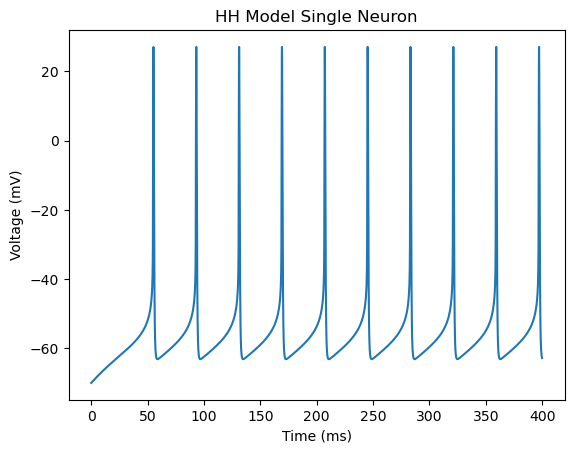

In [74]:
nrn = neurons[0]
print(vars(nrn))
plt.figure()
plt.plot(param.tarray,nrn.soln_history[3])
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (mV)')
plt.title('HH Model Single Neuron')